***The filtering function***

***The video generation function***

In [1]:
def create_paved_kymograph(kymo):
    height, width = kymo.shape

    # Duplicate and manipulate images
    subFourier1 = kymo.copy()
    subFourier2 = cv2.flip(kymo, 1)  # Flip horizontally
    subFourier3 = cv2.flip(subFourier2, 0)  # Flip vertically after horizontal
    subFourier4 = cv2.flip(kymo, 0)  # Flip vertically

    # Create a larger image and place manipulated images accordingly
    filter_forward = np.zeros((3 * height, 3 * width), dtype=kymo.dtype)
    filter_forward[height:2*height, width:2*width] = subFourier1
    filter_forward[height:2*height, 0:width] = subFourier2
    filter_forward[height:2*height, 2*width:3*width] = subFourier2
    filter_forward[0:height, 0:width] = subFourier3
    filter_forward[0:height, 2*width:3*width] = subFourier3
    filter_forward[2*height:3*height, 0:width] = subFourier3
    filter_forward[2*height:3*height, 2*width:3*width] = subFourier3
    filter_forward[0:height, width:2*width] = subFourier4
    filter_forward[2*height:3*height, width:2*width] = subFourier4
    return filter_forward
    
def apply_fourier_operations(tiled_image):
    dft = np.fft.fftshift(np.fft.fft2(tiled_image))  # Apply FFT and shift zero frequency to center
    # Zero out specific regions in the Fourier transform
    h, w = dft.shape
    # Horizontal line across the middle
    dft[h//2-1:h//2+1, :] = 0
    # Top-left quadrant
    dft[:h//2, :w//2] = 0
    # botom-right quadrant
    dft[h//2:, w//2:] = 0
    
    # Inverse Fourier Transform
    inverse_dft = np.fft.ifft2(np.fft.ifftshift(dft)).real

    return inverse_dft

def filter_kymo_left(kymo):
    height, width = kymo.shape
    paved_kymo = create_paved_kymograph(kymo)
    paved_kymo_filter = apply_fourier_operations(paved_kymo)
    paved_kymo = create_paved_kymograph(kymo)
    filtered_kymo = paved_kymo_filter[height:2*height, width:2*width]
    filtered_kymo -= np.percentile(filtered_kymo,10)
    # filtered_kymo[np.where(filtered_kymo<0)] =0
    
    return(filtered_kymo)
    
def filter_kymo_right(kymo):
    return(np.flip(filter_kymo_left(np.flip(kymo, axis=1)), axis=1))

In [12]:
import numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio

%matplotlib widget
class MovingSpotsVideo:
    def __init__(self, rect_size, left_speed, right_speed, num_spots,num_spots_imobile,bias = 0.5,gaussian_range = (5,20),amplitude_range = (1,10)):
        self.rect_size = rect_size
        self.x, self.y = np.meshgrid(np.linspace(0, self.rect_size[1], self.rect_size[1]), 
                                     np.linspace(0, self.rect_size[0], self.rect_size[0]))
        self.left_speed = left_speed
        self.right_speed = right_speed
        num_spots_left = int(num_spots*bias)
        num_spots_right = int(num_spots*(1-bias))
        self.gaussian_range = gaussian_range
        self.amplitude_range = amplitude_range
        self.bias = bias
        self.spots_right = self.create_initial_spots(num_spots_left)
        self.spots_left = self.create_initial_spots(num_spots_right)
        self.spots_imobile = self.create_initial_spots(num_spots_imobile)

        self.flux = bias * left_speed+(1-bias)*right_speed

    def create_gaussian_spot(self, center):
        # Modified distance calculation for wrapping
        dx = np.minimum(np.abs(self.x - center[1]), self.rect_size[1] - np.abs(self.x - center[1]))
        dy = np.minimum(np.abs(self.y - center[0]), self.rect_size[0] - np.abs(self.y - center[0]))
        d = np.sqrt(dx**2 + dy**2)

        sigma, amplitude = np.random.randint(*self.gaussian_range), np.random.randint(*self.amplitude_range)
        gaussian = amplitude * np.exp(-(d**2 / (2.0 * sigma**2)))
        return gaussian

    def create_initial_spots(self, num_spots):
        initial_image = np.zeros(self.rect_size)
        for _ in range(num_spots):
            center_x = np.random.randint(0, self.rect_size[0])
            center_y = np.random.randint(0, self.rect_size[1])
            gaussian_spot = self.create_gaussian_spot((center_x, center_y))
            initial_image += gaussian_spot

        # Normalize to avoid saturation

        return initial_image


    def move_window(self, initial_img, speed, t):
        shift = int(speed * t)
        if speed > 0:  # Moving right
            moved_img = np.roll(initial_img, shift, axis=1)
        else:  # Moving left
            moved_img = np.roll(initial_img, shift, axis=1)
        return moved_img

    def generate_video(self, num_timesteps,noise_level = 1):
        frames = []
        frames_right= []
        frames_left= []
        
        for t in range(num_timesteps):
            frame_right = self.move_window(self.spots_right, self.right_speed, t)
            frame_left = self.move_window(self.spots_left, self.left_speed, t)
            frame_immobile = self.move_window(self.spots_imobile, 0, t)
            frame_right_mod = cv2.addWeighted(frame_right, 1, frame_immobile, 0.5, 0)
            frame_left_mod = cv2.addWeighted(frame_left, 1, frame_immobile, 0.5, 0)

            frame = cv2.addWeighted(frame_right_mod, 1, frame_left_mod, 1, 0)
            frame += (np.random.random(size = frame.shape)*2-1)*noise_level
            
            frames.append(frame)
            frames_right.append(frame_right)
            frames_left.append(frame_left)
        return frames,frames_right,frames_left
    def get_kymo(self,num_timesteps,noise_level = 1):
        frames,frames_right,frames_left = self.generate_video(num_timesteps,noise_level = noise_level)
        kymo = np.mean(frames,axis=1)
        filtered_kymo_left = filter_kymo_left(kymo)
        filtered_kymo_right = filter_kymo_right(kymo)
        
        return(kymo,filtered_kymo_left,filtered_kymo_right,np.mean(frames_left,axis=1),np.mean(frames_right,axis=1),)
video_generator = MovingSpotsVideo(rect_size=(112, 112*5), left_speed=20, right_speed=-30,gaussian_range = (5,20), num_spots=30,num_spots_imobile=10,bias = 0.7)
frames,frames_right,frames_left = video_generator.generate_video(num_timesteps=20,noise_level = 5)

***An example of a video generation***

In [13]:
frames_normalize = cv2.normalize(np.array(frames), None, 0, 254, cv2.NORM_MINMAX, dtype=cv2.CV_8U).astype(np.uint8)
rescaled_images = [img for img in frames_normalize]


In [14]:
import os
path = r"C:\Users\coren\Documents\PhD\paper\transport\SI\SI_video\frames"
for i,frame in enumerate(rescaled_images):
    imageio.imsave(os.path.join(path,f"frame{i}.png"),frame)

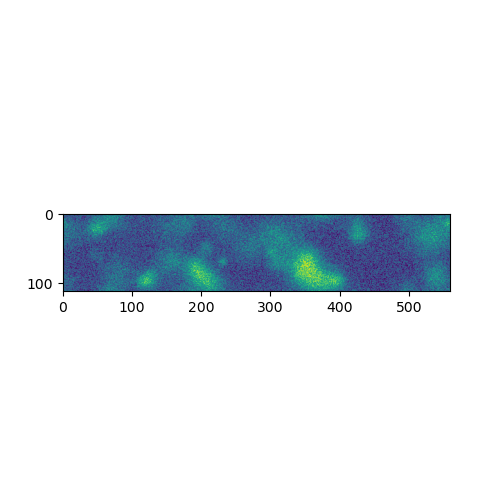

In [11]:
imageio.mimsave('test.mp4',rescaled_images, 'ffmpeg')
fig, ax = plt.subplots(figsize = (5,5))
ax.imshow(frames[2])



***Test if left kymograph is correctly filtered***

C:\Users\coren\AppData\Local\Temp\ipykernel_19760\2053877986.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(sizex, sizey), sharex=True)


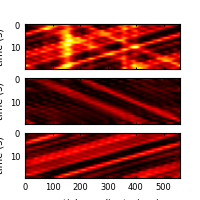

In [30]:
plt.style.use('presentation.mplstyle')

path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\SI"
kymo = video_generator.get_kymo(20,noise_level = 0)[0]
# kymo = np.flip(kymo,axis=1)
height, width = kymo.shape

max_kymo = np.max(kymo)
sizey = 2
sizex = 2
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(sizex, sizey), sharex=True)
ax1.imshow(kymo, aspect='auto',cmap="hot",vmin=0,vmax= max_kymo)

filtered_kymo_left = filter_kymo_left(kymo)
filtered_kymo_right = filter_kymo_right(kymo)

ax2.imshow(filtered_kymo_left, aspect='auto',cmap="hot",vmin=0,vmax= max_kymo)

ax3.imshow(filtered_kymo_right, aspect='auto',cmap="hot",vmin=0,vmax= max_kymo)
ax3.set_xlabel('spatial coordinate ($\mu m$)')
for ax in (ax1,ax2,ax3):
    ax.set_ylabel('time (s)')
plt.savefig(os.path.join(path_figure,f'example_kymos.pdf'), transparent=True, bbox_inches='tight')
    

***Generate samples***

This will take a bit of time

In [22]:


# Parameters for dataset generation
num_timesteps = 20  # Number of timesteps in each video
rect_size=(112, 112*5)
size_kymo = 400
def generate_sample():
    # Randomly choose parameters within a reasonable range
    left_speed = np.random.uniform(10, 60)
    right_speed = np.random.uniform(-60, -10)
    num_spots = np.random.randint(50, 1000)
    # num_spots_imobile = np.random.randint(50, 500)
    num_spots_imobile = np.random.randint(1, 5)
    
    noise_level = np.random.randint(0, 5)
    bias = np.random.uniform(0, 1)
    gaussian_range = (5,20)
    amplitude_range = (1, 2)
    # Create a video generator
    video_generator = MovingSpotsVideo(rect_size, left_speed, right_speed, num_spots,num_spots_imobile, bias, gaussian_range, amplitude_range)
    
    # Generate kymograph
    kymograph,filtered_kymo_left,filtered_kymo_right,left_kymo,right_kymo = video_generator.get_kymo(num_timesteps,noise_level = noise_level)
    # kymograph += np.random.random(size = kymograph.shape)/200*noise_level*0
    # Get flux value
    flux = video_generator.flux
    kymo = kymograph
    filtered_kymo_left = filter_kymo_left(kymo)
    filtered_kymo_right = filter_kymo_right(kymo)
    return kymo,filtered_kymo_left,filtered_kymo_right, flux,left_kymo,right_kymo

In [23]:
from tqdm import tqdm
num_samples = 100 # Number of samples in the dataset

# Generate dataset
X = []
y = []
original_kymo_left = []
original_kymo_right = []

fourrier_kymo_left = []
fourrier_kymo_right = []


for _ in tqdm(range(num_samples), desc="Generating Samples"):
    kymo,filtered_kymo_left,filtered_kymo_right, flux,left_kymo,right_kymo= generate_sample()
    filtered_left_norm = (filtered_kymo_left - np.mean(kymo)) / np.std(kymo)
    filtered_right_norm = (filtered_kymo_right - np.mean(kymo)) / np.std(kymo)
    kymo_norm = (kymo - np.mean(kymo)) / np.std(kymo)
    # Stack the images along the new axis
    combined_image = np.stack([kymo_norm, filtered_left_norm, filtered_right_norm], axis=-1)

    # Add to the X array
    X.append(combined_image)
    y.append((left_kymo - np.mean(kymo)) / np.std(kymo))
    original_kymo_left.append(left_kymo)
    original_kymo_right.append(right_kymo)
    
    fourrier_kymo_left.append(filtered_kymo_left)
    fourrier_kymo_right.append(filtered_kymo_right)
    
    
    

X = np.array(X).reshape(-1, num_timesteps, size_kymo, 3)
y = np.array(y)

# Split dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Generating Samples: 100%|████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22it/s]


***Test the intensity match***

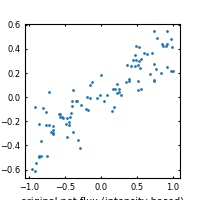

In [28]:
import pandas as pd

# Calculating the means
mean_original_left = np.mean(original_kymo_left, axis=(1, 2))
mean_fourrier_left = np.mean(fourrier_kymo_left, axis=(1, 2))
mean_original_right = np.mean(original_kymo_right, axis=(1, 2))
mean_fourrier_right = np.mean(fourrier_kymo_right, axis=(1, 2))

df = pd.DataFrame({
    'original_left': mean_original_left,
    'fourrier_left': mean_fourrier_left,
    'original_right': mean_original_right,
    'fourrier_right': mean_fourrier_right,
    
    
})
df = df.sort_values(by="original_left")
df['net_flux_original'] = (df['original_left']-df['original_right'])/(df['original_left']+df['original_right'])
df['net_flux_fourrier'] = (df['fourrier_left']-df['fourrier_right'])/(df['fourrier_left']+df['fourrier_right'])
df['total_flux_original'] = df['original_left']+df['original_right']
df['total_flux_fourrier'] = df['fourrier_left']+df['fourrier_right']

# window_size = 10
# rolling_avg_original = df['fourrier_left'].rolling(window=window_size,min_periods = 10).mean()
# fig, ax = plt.subplots(figsize = (5,5))
# ax.scatter(df['original_left'],df['fourrier_left'])
# ax.plot(df['original_left'],rolling_avg_original,color="red",linewidth = 10)
# df = df.sort_values(by="net_flux_original")
# ax.set_xlabel('original left intensity')
# ax.set_ylabel('fourrier extracted \n left intensity')



window_size = 10
rolling_avg_original = df['net_flux_fourrier'].rolling(window=window_size,min_periods = 10).mean()
fig, ax = plt.subplots(figsize = (2,2))
ax.scatter(df['net_flux_original'],df['net_flux_fourrier'])
# ax.plot(df['net_flux_original'],rolling_avg_original,color="red",linewidth = 10)
df = df.sort_values(by="total_flux_original")
ax.set_xlabel('original net flux (intensity based)')
ax.set_ylabel('fourrier extracted \n net flux')
plt.savefig(os.path.join(path_figure,f'flux_extration.pdf'), transparent=True, bbox_inches='tight')